<a href="https://colab.research.google.com/github/armandoalbornoz/replicating_paper/blob/main/Deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pytorch Model Deployment

## Get Data

We are going to use the 20% pizza, steak, sushi dataset.

In [104]:
# Setup
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [105]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Getting Data

In [106]:

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path


[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


PosixPath('data/pizza_steak_sushi_20_percent')

In [107]:
# Setup directory paths to train and test images
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

## Experiments

We are going to build two models:

1. EffNetB2 feature extractor
2. ViT feature extractor

Our goal is to pick a model that is both fast and accurate.

## Creating EffNetB2 feature extractor



In [108]:
# Get pretrained model and transforms
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
transforms = effnetb2_weights.transforms()
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights).to(device)

# Freeze base layers
for param in effnetb2.features.parameters():
    param.requires_grad = False

In [109]:
from torchinfo import summary

summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [110]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [111]:
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408,
              out_features=3,
              bias=True)).to(device)

In [112]:
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [113]:
def create_effnetb2_model(num_classes=3):

  effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = effnetb2_weights.transforms()
  effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights).to(device)

  # Freeze base layers
  for param in effnetb2.features.parameters():
      param.requires_grad = False

  effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408,
              out_features=num_classes,
              bias=True)).to(device)

  return effnetb2, transforms

In [114]:
effnetb2, effnetb2_transforms = create_effnetb2_model(3)

In [115]:
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### Creating Dataloaders for EffNetB2



In [116]:
from going_modular.going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=effnetb2_transforms,
    batch_size=32
)

## Training EffNetB2 feature extractor

In [117]:
optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [118]:
from going_modular.going_modular import engine

effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9729 | train_acc: 0.5583 | test_loss: 0.7328 | test_acc: 0.9068
Epoch: 2 | train_loss: 0.7208 | train_acc: 0.8292 | test_loss: 0.5973 | test_acc: 0.9625
Epoch: 3 | train_loss: 0.5835 | train_acc: 0.8354 | test_loss: 0.4926 | test_acc: 0.9256
Epoch: 4 | train_loss: 0.4883 | train_acc: 0.8833 | test_loss: 0.4352 | test_acc: 0.9563
Epoch: 5 | train_loss: 0.4652 | train_acc: 0.8750 | test_loss: 0.3788 | test_acc: 0.9688
Epoch: 6 | train_loss: 0.4625 | train_acc: 0.8396 | test_loss: 0.3505 | test_acc: 0.9284
Epoch: 7 | train_loss: 0.4268 | train_acc: 0.8688 | test_loss: 0.3327 | test_acc: 0.9659
Epoch: 8 | train_loss: 0.3383 | train_acc: 0.9104 | test_loss: 0.3168 | test_acc: 0.9534
Epoch: 9 | train_loss: 0.2872 | train_acc: 0.9354 | test_loss: 0.2997 | test_acc: 0.9500
Epoch: 10 | train_loss: 0.3709 | train_acc: 0.8979 | test_loss: 0.2688 | test_acc: 0.9750


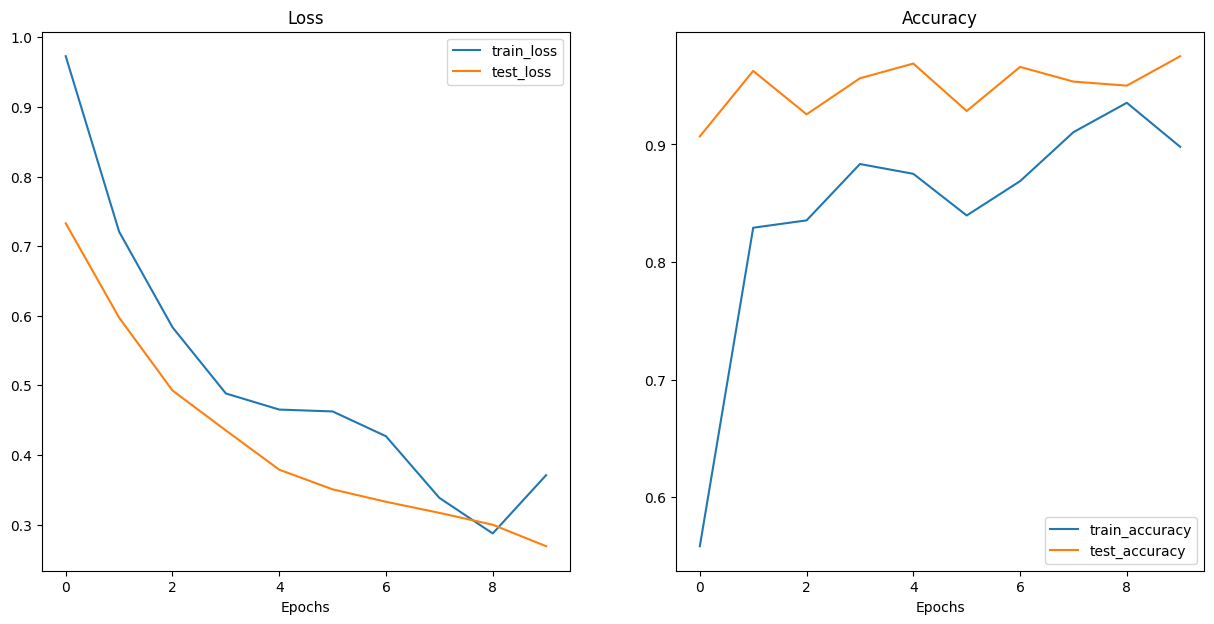

In [119]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

## Saving EffNetB2 feature extractor

In [120]:
from going_modular.going_modular import utils

utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="pretrained_effnetb2_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/pretrained_effnetb2_feature_extractor_pizza_steak_sushi.pth


### Inspecting size of model

In [121]:
from pathlib import Path

model_path = Path("models/pretrained_effnetb2_feature_extractor_pizza_steak_sushi.pth")
model_size_mb = model_path.stat().st_size / (1024 * 1024)
print(f"Model size: {model_size_mb:.2f} MB")

Model size: 29.85 MB


## Collecting EffNetB2 properties

In [122]:
# Count the number of parameters
total_params = sum(torch.numel(param) for param in effnetb2.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 7705221


In [123]:
# Create a dictionary with the statistics

effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters" : total_params ,
                  "model_size (MB)" :model_size_mb
                  }

In [124]:
effnetb2_stats

{'test_loss': 0.2688239485025406,
 'test_acc': 0.975,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.8526554107666}

## Creating the ViT model

In [125]:
def create_vit_model(num_classes=3):

  vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = vit_weights.transforms()
  vit = torchvision.models.vit_b_16(weights=vit_weights).to(device)

  # Freeze base layers
  for param in vit.parameters():
      param.requires_grad = False

  vit.heads


  vit.heads = nn.Sequential(
    nn.Linear(in_features=768,
              out_features=num_classes,
              bias=True)).to(device)

  return vit, transforms

In [126]:
vit, vit_transforms = create_vit_model(3)
summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

## Creating Dataloaders

In [127]:
# Creating Dataloaders for vit

from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vit_transforms,
    batch_size=32
)

## Vit Training

In [128]:
optimizer = torch.optim.Adam(params=vit.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [129]:
from going_modular.going_modular import engine

vit_results = engine.train(model=vit,
                                train_dataloader=train_dataloader_vit,
                                test_dataloader=test_dataloader_vit,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5378 | train_acc: 0.8708 | test_loss: 0.2191 | test_acc: 0.9631
Epoch: 2 | train_loss: 0.1930 | train_acc: 0.9521 | test_loss: 0.1178 | test_acc: 0.9722
Epoch: 3 | train_loss: 0.1444 | train_acc: 0.9625 | test_loss: 0.0934 | test_acc: 0.9722
Epoch: 4 | train_loss: 0.1147 | train_acc: 0.9688 | test_loss: 0.0829 | test_acc: 0.9784
Epoch: 5 | train_loss: 0.0947 | train_acc: 0.9729 | test_loss: 0.0756 | test_acc: 0.9722
Epoch: 6 | train_loss: 0.0815 | train_acc: 0.9771 | test_loss: 0.0729 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0811 | train_acc: 0.9792 | test_loss: 0.0690 | test_acc: 0.9722
Epoch: 8 | train_loss: 0.0603 | train_acc: 0.9875 | test_loss: 0.0655 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0530 | train_acc: 0.9917 | test_loss: 0.0653 | test_acc: 0.9659
Epoch: 10 | train_loss: 0.0468 | train_acc: 0.9958 | test_loss: 0.0667 | test_acc: 0.9784


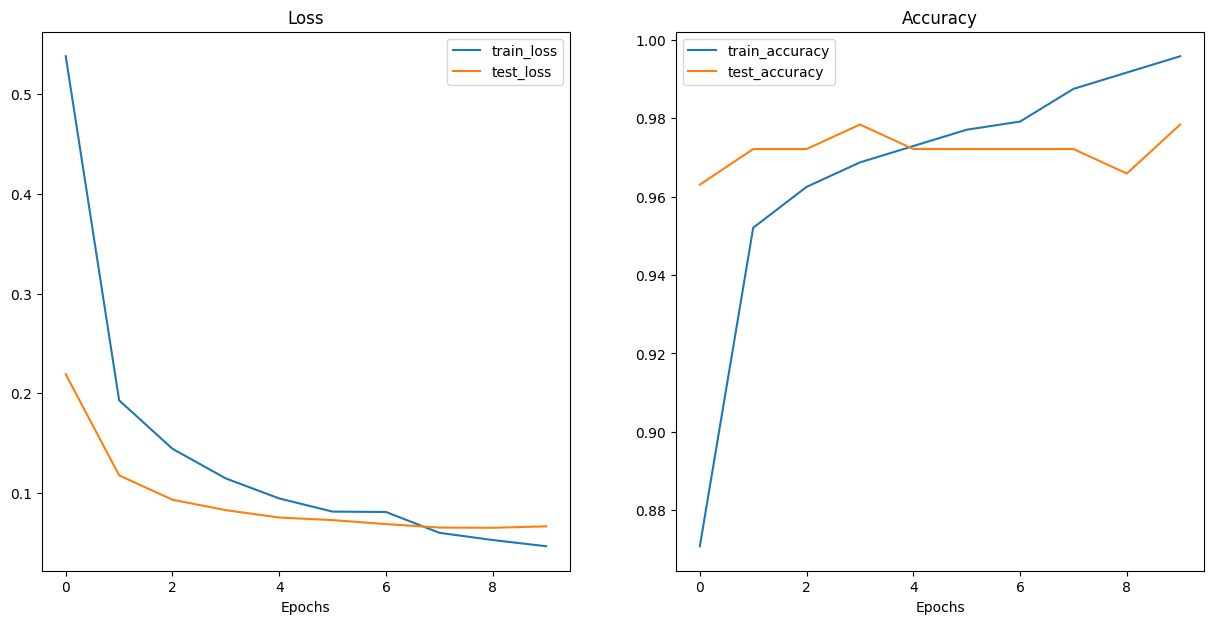

In [130]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

## Saving Vit Model

In [131]:
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="pretrained_vit_b_16_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/pretrained_vit_b_16_feature_extractor_pizza_steak_sushi.pth


## Inspecting size of model


In [132]:
from pathlib import Path

model_path = Path("models/pretrained_vit_b_16_feature_extractor_pizza_steak_sushi.pth")
model_size_mb = model_path.stat().st_size / (1024 * 1024)
print(f"Model size: {model_size_mb:.2f} MB")

Model size: 327.37 MB


## Collecting Vit feuature extractor properties

In [133]:
# Count the number of parameters
total_params = sum(torch.numel(param) for param in vit.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 85800963


In [134]:
# Create a dictionary with the statistics

vit_stats = {"test_loss": vit_results["test_loss"][-1],
                  "test_acc": vit_results["test_acc"][-1],
                  "number_of_parameters" : total_params ,
                  "model_size (MB)" :model_size_mb
                  }

In [135]:
vit_stats

{'test_loss': 0.0667094960808754,
 'test_acc': 0.978409090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.3695697784424}

## Making predictions with our models and timing them

In [136]:
from pathlib import Path

# get all test data paths

test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:10]

[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/39461.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1902895.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/219196.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3173402.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/399377.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1166047.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2475366.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/595836.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/108310.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2315011.jpg')]

In [142]:
## Let's create a function that makes predictionss across the dataset

import pathlib
import torch
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
  pred_list = []

  # Loop through the paths

  for path in tqdm(paths):
    # Create an dictionary for each sample
    pred_dict = {}

    # Get the sample path and label frrom the filepath
    pred_dict["image_path"] = path
    class_name = path.parent.name
    pred_dict["class_name"] = class_name

    # Start the prediction timer
    start_time= timer()

    img = Image.open(path)

    transformed_img = transform(img).unsqueeze(0).to(device) # We also add a batch dimension

    model = model.to(device)
    model.eval()

    with torch.inference_mode():
      pred_logits = model(transformed_img)
      pred_probs = torch.softmax(pred_logits, dim=1)
      pred_label = torch.argmax(pred_probs, dim=1)
      pred_class = class_names[pred_label.cpu()] # harcode prediction class to be on CPU (Python variables live on CPU)


      pred_dict["pred_prob"] = round(pred_probs.max().item(), 4)
      pred_dict["pred_class"] =  pred_class

      end_timer = timer()
      pred_dict["prediction_time"] = round(end_timer - start_time, 4)

    pred_dict["correct"] = class_name == pred_class

    pred_list.append(pred_dict)

  return pred_list

## EffnetB2 making and timing predictions

1. Our predictions will happen on the CPU since not all devices have a GPU.




In [143]:
effnetb2_test_predictions = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [144]:
effnetb2_test_predictions[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/39461.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.5283,
  'pred_class': 'steak',
  'prediction_time': 0.1285,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1902895.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.4512,
  'pred_class': 'sushi',
  'prediction_time': 0.1009,
  'correct': False}]

In [146]:
# Turn the list of dictionaries into a dataframe

import pandas as pd

effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_predictions)
effnetb2_test_pred_df

,image_path,class_name,pred_prob,pred_class,prediction_time,correct
0,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.5283,steak,0.1285,True
1,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.4512,sushi,0.1009,False
2,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9017,steak,0.1098,True
3,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.8850,steak,0.1026,True
4,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.7212,steak,0.1029,True
...,...,...,...,...,...,...
145,data/pizza_steak_sushi_20_percent/test/sushi/4...,sushi,0.8632,sushi,0.1601,True
146,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.6780,sushi,0.1576,True
147,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.8474,sushi,0.1654,True
148,data/pizza_steak_sushi_20_percent/test/sushi/5...,sushi,0.5211,sushi,0.1523,True


In [147]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

,count
correct,
True,146
False,4


In [149]:
# Let's find the average time per prediction

effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.prediction_time.mean(), 4)
effnetb2_average_time_per_pred

np.float64(0.1164)

## ViT making and timing predictions


In [154]:
vit_test_predictions = pred_and_store(paths=test_data_paths,
                                          model=vit,
                                          transform=vit_transforms,
                                          class_names=class_names,
                                          device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [157]:
vit_test_predictions[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/39461.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.8465,
  'pred_class': 'steak',
  'prediction_time': 0.5696,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1902895.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.5792,
  'pred_class': 'steak',
  'prediction_time': 0.5723,
  'correct': True}]

In [158]:
# Turn the list of dictionaries into a dataframe

import pandas as pd

vit_test_pred_df = pd.DataFrame(vit_test_predictions)
vit_test_pred_df

,image_path,class_name,pred_prob,pred_class,prediction_time,correct
0,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.8465,steak,0.5696,True
1,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.5792,steak,0.5723,True
2,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9950,steak,0.5778,True
3,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.9965,steak,0.5743,True
4,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.9359,steak,0.5699,True
...,...,...,...,...,...,...
145,data/pizza_steak_sushi_20_percent/test/sushi/4...,sushi,0.9982,sushi,0.5766,True
146,data/pizza_steak_sushi_20_percent/test/sushi/3...,sushi,0.9920,sushi,0.5615,True
147,data/pizza_steak_sushi_20_percent/test/sushi/1...,sushi,0.9923,sushi,0.5656,True
148,data/pizza_steak_sushi_20_percent/test/sushi/5...,sushi,0.9383,sushi,0.5736,True


In [159]:
# Check number of correct predictions
vit_test_pred_df.correct.value_counts()

,count
correct,
True,147
False,3


In [161]:
# Let's find the average time per prediction

vit_average_time_per_pred = round(vit_test_pred_df.prediction_time.mean(), 4)
vit_average_time_per_pred

np.float64(0.613)

In [162]:
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred

({'test_loss': 0.0667094960808754,
  'test_acc': 0.978409090909091,
  'number_of_parameters': 85800963,
  'model_size (MB)': 327.3695697784424,
  'time_per_pred_cpu': np.float64(0.613)},
 {'test_loss': 0.2688239485025406,
  'test_acc': 0.975,
  'number_of_parameters': 7705221,
  'model_size (MB)': 29.8526554107666,
  'time_per_pred_cpu': np.float64(0.1164)})

## Comparing model results, prediction time and size of the models

In [167]:
df = pd.DataFrame([effnetb2_stats, vit_stats])
df["model"] = ["EffNetB2", "ViT"]
df["test_acc"] = round(df["test_acc"] * 100, 2 )
df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.268824,97.50,7705221,29.852655,0.1164,EffNetB2
1,0.066709,97.84,85800963,327.369570,0.6130,ViT


# Ratio Comparisons

In [168]:
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]),
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.248153,1.003487,11.135432,10.966179,5.266323


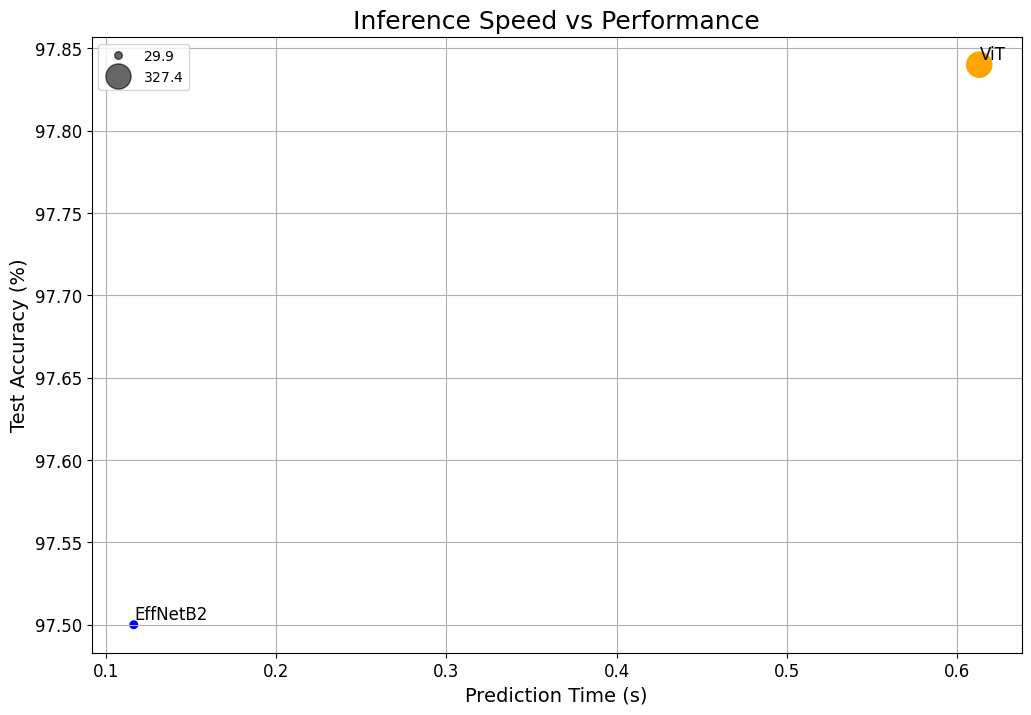

In [186]:
fig, ax = plt.subplots(figsize=(12,8))
scatter = ax.scatter(data=df, x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"],
                     s="model_size (MB)")

ax.set_title("Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction Time (s)", fontsize=14)
ax.set_ylabel("Test Accuracy (%)", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
ax.grid(True)

for index, row in df.iterrows():
  ax.annotate(text=row["model"],
              xy=(row["time_per_pred_cpu"] + 0.0006, row["test_acc"] + 0.003),
              size=12)

  handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
  model_size_legend = ax.legend(handles, labels, loc="upper left")

  ## Save the figure
  plt.savefig("images/inference_speed_vs_performance.png")